<a href="https://colab.research.google.com/github/Ele975/ML_project2/blob/main/AML_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Natural Language Processing
Authors: Zechen Wu, Elena Franchini, Erifeoluwa Jamgbadi

In [1]:
!git clone https://github.com/Ele975/AML_project2.git
!pip install --upgrade gensim
!pip install ffmpeg-python
!pip install -U openai-whisper
!pip install noisereduce
!pip install pydub
!pip install transformers
!pip install openai

Cloning into 'AML_project2'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 163 (delta 48), reused 54 (delta 36), pack-reused 85 (from 1)
Receiving objects: 100% (163/163), 58.03 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (77/77), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 16.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=234824ef6aba518653601a3a1e9ee111db0af2d5db1a9ef1acd88bc945f4cf78
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Su

In [4]:
import pandas as pd
import numpy as np
import json
import math
import io
import re
import nltk
import ffmpeg
import whisper
import scipy
import urllib.request
import librosa
import matplotlib
import noisereduce as nr
import torch
import openai
import json
import logging
import time
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from gensim.models import phrases
from matplotlib import pyplot as plt
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
from google.colab import drive
from transformers import AutoTokenizer,BertTokenizerFast
from transformers import GPT2LMHeadModel, GPT2Tokenizer

nltk.download('stopwords')
drive.mount('/content/drive')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/drive


In [7]:
# import data from github repository
train = pd.read_json('AML_project2/datasets/squadtrain-v2.0.json')
val = pd.read_json('AML_project2/datasets/squaddev-v2.0.json')
print(train[:10])
print(val[:10])

  version                                               data
0    v2.0  {'title': 'Beyoncé', 'paragraphs': [{'qas': [{...
1    v2.0  {'title': 'Frédéric_Chopin', 'paragraphs': [{'...
2    v2.0  {'title': 'Sino-Tibetan_relations_during_the_M...
3    v2.0  {'title': 'IPod', 'paragraphs': [{'qas': [{'qu...
4    v2.0  {'title': 'The_Legend_of_Zelda:_Twilight_Princ...
5    v2.0  {'title': 'Spectre_(2015_film)', 'paragraphs':...
6    v2.0  {'title': '2008_Sichuan_earthquake', 'paragrap...
7    v2.0  {'title': 'New_York_City', 'paragraphs': [{'qa...
8    v2.0  {'title': 'To_Kill_a_Mockingbird', 'paragraphs...
9    v2.0  {'title': 'Solar_energy', 'paragraphs': [{'qas...
  version                                               data
0    v2.0  {'title': 'Normans', 'paragraphs': [{'qas': [{...
1    v2.0  {'title': 'Computational_complexity_theory', '...
2    v2.0  {'title': 'Southern_California', 'paragraphs':...
3    v2.0  {'title': 'Sky_(United_Kingdom)', 'paragraphs'...
4    v2.0  {'title': 'Vi

# Investigate dataset

## Dataset selection
The dataset we will use is the "SQuAD2.0: The Stanford Question Answering Dataset". The website provides the training and validation (i.e. development) set in the form of JSON.


## Dataset analysis
Data in the training set consists of strings which represent questions and answers (that come from Wikipedia articles) and can be found as values under the 'data' key. Each 'title' key is associated to a 'paragraphs' key which is an array containing these questions and answers associated to that title (the title acts as a category). Each question is composed by the text representing the question, the id, an array of answers and a flag checking if answering to that question is impossible: if the flag is true, the array of answers is empty. In addition, each answer is associated to the 'answer_start' key whose value represent the starting position of the answer.
Some questions have also plausible answers, which should be other possible answers in addition to the correct ones (if any).

### Count the number of data we have in both the training and validation sets.
The size of the dataset is quite small, but the partition between the training and validation set is good (since always we have a traning set much bigger than the validation set). Often the dataset is first split in traning and test set, since the validation set is obtained by further splitting the training set, but this is not the case.

In [8]:
def count_data(series):
  nr_titles = 0
  nr_questions = 0
  nr_answers = 0
  nr_contexts = 0

  for title in series:
    nr_titles += 1
    paragraphs = title.get('paragraphs', [])
    # each para contains multiple dictionaries {qas, context}. Each qas contains more questions and can contains more answers for a single question. Each qas is associated with a single context
    for para in paragraphs:
      if 'context' in para:
        nr_contexts += 1
      qas_list = para.get('qas', [])
      nr_questions += len(qas_list)
      for qas in qas_list:
        answers = qas.get('answers', [])
        questions = qas.get('question', [])
        nr_answers += len(answers)
        if 'plausible_answers' in qas:
          nr_answers += 1


  return nr_titles, nr_questions, nr_answers, nr_contexts

count_train = count_data(train['data'])
count_val = count_data(val['data']);

print("Titles (categories) in the training set:", count_train[0])
print("Titles (categories) in the validation set:", count_val[0], "\n")
# There is a context for each group of questions and answers
print("Contexts in the training set:", count_train[3])
print("Contexts in the validation set:", count_val[3], "\n")
print("Questions in the training set:", count_train[1])
print("Questions in the validation set:", count_val[1], "\n")
print("Answers in the training set:", count_train[2])
print("Answers in the validation set:", count_val[2], "\n")

print('Total Q + A in training set:', count_train[1] + count_train[2])
print('Total Q + A in validation set:', count_val[1] + count_val[2], "\n")

print('Total Q + A in dataset:', count_train[1] + count_train[2] + count_val[1] + count_val[2], "\n")

print('Partition dataset (counting Q and A):')
print('\t Training set:',round((count_train[1] + count_train[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')
print('\t Validation set:',round((count_val[1] + count_val[2])/(count_train[1] + count_train[2] + count_val[1] + count_val[2])*100) , '%.')

Titles (categories) in the training set: 442
Titles (categories) in the validation set: 35 

Contexts in the training set: 19035
Contexts in the validation set: 1204 

Questions in the training set: 130319
Questions in the validation set: 11873 

Answers in the training set: 130319
Answers in the validation set: 26247 

Total Q + A in training set: 260638
Total Q + A in validation set: 38120 

Total Q + A in dataset: 298758 

Partition dataset (counting Q and A):
	 Training set: 87 %.
	 Validation set: 13 %.


### Define the vocabulary size which is given by the number of distinct words in the collection.
To compute the size of the vocabulary we need first to split the sentences strings into words and inserting them in a set which do not allow duplicates (the vocabulary size takes into consideration only distinct words). Regex are used to remove characters we don't need for the analysis, e.g. underscores, numbers, etc. Stop words (most common words) are removed since they don't give additional value for our statistics. In the vocabulary size there are also considered some wrong written words (e.g. aan instead of 'an'), and it is not performant to remove them manually, but since they are only a few with respect to the amount of different words we have, they'll do not influence our results.

The vocabulary takes into consideration all sentences of the collection (titles, contexts, questions, answers)

In [10]:

# all words of both sets (frequency = n)
words_total = []
# unique words for both sets (frequency = 1)
words_set_total = set()


def regex_clean(sentence):
  sentence = sentence.lower()
  # Remove non-alphanumeric characters and spaces (maintain '-')
  sentence = re.sub(r'[^\w\s/-]', '', sentence)
  # Replace '/' with space
  sentence = re.sub(r'/', ' ', sentence)
  # Replace underscores with space
  sentence = re.sub(r'_', ' ', sentence)
  # Remove standalone numbers
  sentence = re.sub(r'\b(?:\d+\s*)+\b', '', sentence)
  # Split the sentence into tokens
  tokens = sentence.split()
  return tokens

def stopwords_removal(tokens):
  nostopwords = [w for w in tokens if w not in stopwords.words('english')]
  return nostopwords


def input_vocabulary(series):
  # unique words for each single set (frequency = 1)
  words_set = set()
  # all words for each set (frequency = n)
  words_total_sets = []
  # list of tokenised questions
  text_to_sentence = []
  c = 0
  for title in series:
    title_tok = regex_clean(title.get('title', []))
    title_tok_clean = stopwords_removal(title_tok)

    text_to_sentence.append(title_tok_clean)
    words_set.update(title_tok_clean)
    words_total_sets.extend(title_tok_clean)
    words_total.extend(title_tok_clean)
    words_set_total.update(title_tok_clean)

    paragraphs = title.get('paragraphs', [])
    for para in paragraphs:
      context_tok = regex_clean(para.get('context', []))
      context_tok_clean = stopwords_removal(context_tok)

      text_to_sentence.append(context_tok_clean)
      words_set.update(context_tok_clean)
      words_total_sets.extend(context_tok_clean)
      words_total.extend(context_tok_clean)
      words_set_total.update(context_tok_clean)

      qas_list = para.get('qas', [])
      for qas in qas_list:
        question = qas.get('question', '')
        words = regex_clean(question)
        words_nostopwords = stopwords_removal(words)

        text_to_sentence.append(words_nostopwords)
        words_set.update(words_nostopwords)
        words_total_sets.extend(words_nostopwords)
        words_total.extend(words_nostopwords)
        words_set_total.update(words_nostopwords)

        answers = qas.get('answers', '')
        for answer in answers:
          ans = regex_clean((answer['text']))
          ans_nostopwords = stopwords_removal(ans)

          text_to_sentence.append(ans_nostopwords)
          words_set.update(ans_nostopwords)
          words_total_sets.extend(ans_nostopwords)
          words_total.extend(ans_nostopwords)
          words_set_total.update(ans_nostopwords)

        if 'plausible_answers' in qas and len(qas.get('plausible_answers')) > 0:
          pla_ans = qas.get('plausible_answers')[0]['text']
          pla_ans_tok = regex_clean(pla_ans)
          pla_ans_tok_clean = stopwords_removal(pla_ans_tok)

          text_to_sentence.append(pla_ans_tok_clean)
          words_set.update(pla_ans_tok_clean)
          words_total_sets.extend(pla_ans_tok_clean)
          words_total.extend(pla_ans_tok_clean)
          words_set_total.update(pla_ans_tok_clean)

  return words_set, words_total_sets, text_to_sentence


words_set_train, words_total_train, text_to_sentence_train = input_vocabulary(train['data'])
words_set_val, words_total_val, text_to_sentence_val = input_vocabulary(val['data'])

print("vocabulary size of training set:", len(words_set_train))
print("vocabulary size of validation set:", len(words_set_val))
print("total vocabulary size of collection:",  len(words_set_total))


vocabulary size of training set: 99479
vocabulary size of validation set: 18418
total vocabulary size of collection: 103485


### Distributions over document length
To compute the distributions over the document length at first we counts the frequency of each term within the input collection. Here we can notice the words written incorrectly are the ones which can be rarely found in the collection (one or few occurences), but again we cannot remove them since there are a lot of grammatically correct words that also occurs rarely. An additional observation is the fact that the training and validation sets have some of the most frequent words in common (e.g. many, yera, name, type, one, ...).

In [12]:
counts_train = nltk.Counter(words_total_train)
counts_val = nltk.Counter(words_total_val)
counts_total = nltk.Counter(words_total)

print("Words count in training set:")
for key, value in list(counts_train.items())[:10]:
    print(key, value)
print("\nWords count in validation set:")
for key, value in list(counts_val.items())[:10]:
    print(key, value)
print("\nWords count in entire collection:")
for key, value in list(counts_total.items())[:10]:
    print(key, value)

Words count in training set:
beyoncé 369
giselle 2
knowles-carter 1
biːˈjɒnseɪ 1
bee-yon-say 1
born 599
september 1051
american 2844
singer 138
songwriter 23

Words count in validation set:
normans 78
norman 101
nourmands 1
french 447
normands 1
latin 34
normanni 1
people 341
10th 28
11th 23

Words count in entire collection:
beyoncé 369
giselle 2
knowles-carter 1
biːˈjɒnseɪ 1
bee-yon-say 1
born 643
september 1108
american 3054
singer 152
songwriter 23


Plot the distribution of the 10 most common words in the entire collection (training and validation set). We can obviously notice that these words are generally common in text, but despite of this, their value is important with respect to the one of the most common words since they can give a general idea about the majority types of questions. By the result, some words are not useful to get come conclusions (e.g. 'many', 'first'), but others can be more interesting (e.g. 'city' can be associated with questions about population, geography, history, etc., 'year' that can be associated to history questions with a specific year of an event occurred in the past). The resulting graph can tells that there can be many historical and geographical questions.

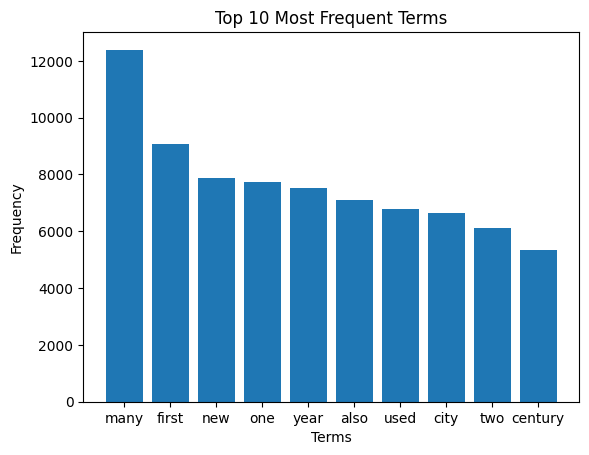

In [ ]:
most_common_words = counts_total.most_common(10)
terms, frequencies = zip(*most_common_words)

# Plot the distribution of the 10 most frequent words
plt.bar(terms, frequencies)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Terms')
plt.show()

## Word2Vec embedding

Word2Vec is used for NLP which is able to produce word embedding (words with similar meaning have similar representation), and with this we can perform many comparisons. Depending on the parameters we use for the Word2Vec model, we'll get different precision as well as different results. The min_count parameter value takes into consideration only the words that occur more than this value in the entire text. In general it is better to drop rare words since they are not similar to any other word and generate 'noise' for the creation of the other vectors. The vector_size parameter defines the number of dimensions the words are mapped onto: the default value is 100 and if we increase it we can have a more accurate model but also we need more training data. The window parameter takes into consideration n words around the target word that affect it.

We trained the model removing stopwords since the results should be more precise and stopwords are not necessary for our purposes. In all cases, the parameter 'sentences' contains the sentences with stop words included.

In [ ]:
sentences = text_to_sentence_train + text_to_sentence_val

# Use a list comprehension to filter out empty arrays
sentences = [subarray for subarray in sentences if len(subarray) > 0]

# train model with text without stopwords
model = Word2Vec(sentences=sentences, vector_size=30, min_count = 5, window=2)

With word embedding using Word2Vec we can perform different types of comparison. The similarity among vectors associated with the terms is computed using the cosine similarity model.

Some examples of tasks we are able to with Word2Vec:
- retrieved the vector associated with the specific word in the dictionary, e.g. 'city'
- retrieve all most similar words to a given term, e.g. 'city', 'food'
- retrieve the word that doesn't match the others in a list
- retrieve the similarity between two words, e.g. 'woman' and 'man'
- retrieve the most similar term to a given word and the similarity value, e.g. 'napoleon', 'child'
- retrieve the similarity between two sets of words

It is interesting to notice that some results are the ones expected (some similar words in meaning are actually recognised as similar), but in other cases the results are not the expected ones. These discrepancies can be due to the parameters passed to the Word2Vec model: in general, a higher value for the parameter vector_size leads to a better accuracy, but for small corpus sizes we can obtain a good accuracy even with small values (i.e. 30 or smaller). The same resoning can be applied to the window value where an higher value leads to an higher quality. Another cause of these misleading results is the size of the training set that in our case is limited and we are not able to increase it. A last reasoning can be made about how to separate the sentences: we used unigrams and this means that each sentence is a list of single words, but it is also possible to use bigrams (or more in general n-grams) since some words are composed by two or more words (e.g. San Francisco, look up, etc.), thus separation in n-grams can be useful to detect and maintain words together. Considering the size of the input, the results are satisfiable, returning in the majority of cases correct similarities among terms.

In [ ]:
# number of word vectors the model learned
res = model.wv
print(len(res), "\n")

# example vector for word 'city'
print("Vector for word 'city':\n", res['city'], "\n")

# similarity with word 'city'
print("Words similar to 'city':\n", res.most_similar("city"), "\n")
print("Words similar to 'food':\n", res.most_similar("food"), "\n")

# word that doesn't match with other words
print("Word not matching 'city, home, food, street':\n",res.doesnt_match("city home food street".split()), "\n")

# expected similarity between two words
similarity = res.similarity('woman', 'man')
print("Similarity between 'man' and 'woman' is greater than 80%:\n", similarity > 0.8, "\n")

# most similar word to the given one
result = res.similar_by_word("napoleon")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'napoleon': \n", f"{most_similar_key}: {similarity:.4f}")

result = res.similar_by_word("child")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'child': \n",f"{most_similar_key}: {similarity:.4f}")

# similarity between two sets of words
similarity = res.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("Similarity between ['sushi', 'shop'] and ['japanese','restaurant']:", similarity)



34408 

Vector for word 'city':
 [-0.61373156 -0.09048129  3.154695    0.14949745  1.0094852  -0.05291523
 -0.8118638   3.1168299  -1.2388426  -0.8186532   0.21800952 -1.3468364
  0.12491129 -0.576056    2.8589554   0.9815114   3.027216   -0.5238168
 -1.6075366  -0.585893    0.3268966  -1.4194688   0.03680319 -0.47094533
 -1.4515154  -1.9636669   0.60830826 -1.6329241   1.2402666   2.2732267 ] 

Words similar to 'city':
 [('town', 0.7919782400131226), ('county', 0.7654625773429871), ('area', 0.7565137147903442), ('paris', 0.754397988319397), ('cities', 0.747930645942688), ('citys', 0.7472111582756042), ('melbourne', 0.7407280802726746), ('plymouth', 0.7319952845573425), ('nanjing', 0.7227296829223633), ('utrecht', 0.7126957178115845)] 

Words similar to 'food':
 [('habitat', 0.9054557681083679), ('waste', 0.9031124711036682), ('crops', 0.8851396441459656), ('resource', 0.878998875617981), ('sanitation', 0.8767069578170776), ('products', 0.8739328980445862), ('soil', 0.868303120136261),

We now compare the results above with the ones obtained increasing the vector_size and window parameters with respective values of 100 and 10. The results are not improved but they're very similar. This means that the parameter's values in this case are not able to obtain better similarity values. This can be due to the fact that the entire document is short enough to not requiring bigger vectors. To improve the vector's values, we should have a bigger input.

In [ ]:
model_precise = Word2Vec(sentences=sentences, vector_size=100, min_count = 5, window=10)

In [ ]:
res = model_precise.wv
print(len(res), "\n")

print("Vector for word 'city':\n", res['city'], "\n")

print("Words similar to 'city':\n", res.most_similar("city"), "\n")
print("Words similar to 'food':\n", res.most_similar("food"), "\n")

print("Word not matching 'city, home, food, street':\n",res.doesnt_match("city home food street".split()), "\n")

similarity = res.similarity('woman', 'man')
print("Similarity between 'man' and 'woman' is greater than 80%:\n", similarity > 0.8, "\n")

result = res.similar_by_word("napoleon")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'napoleon': \n", f"{most_similar_key}: {similarity:.4f}")

result = res.similar_by_word("child")
most_similar_key, similarity = result[0]  # look at the first match
print("Most similar word to 'child': \n",f"{most_similar_key}: {similarity:.4f}")

similarity = res.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("Similarity between ['sushi', 'shop'] and ['japanese','restaurant']:", similarity)

34408 

Vector for word 'city':
 [-6.4372277e-01 -2.6070336e-01 -4.5534474e-01  4.8289737e-01
  2.4428263e+00  1.1176416e+00 -9.1534391e-02 -1.1113414e+00
 -5.1973796e-01  1.7344977e-01  1.0796390e+00 -6.1845803e-01
  2.0042219e+00 -9.2804652e-01  5.2782810e-01  8.0668467e-01
 -5.0024849e-01 -2.2410019e-01 -4.4895401e+00 -1.6479409e+00
 -1.3297495e+00  5.3354615e-01 -2.7536685e+00 -1.9800899e+00
 -1.0984499e+00 -1.4534713e+00  2.7331445e+00  2.1879728e+00
 -1.2925584e+00 -3.9817132e-03 -1.2115095e+00 -1.5457765e+00
 -2.5833285e+00  3.3214970e+00  1.1751796e+00  7.0031214e-01
 -5.6424636e-01 -1.5540574e+00 -2.3773773e+00  1.7633852e+00
  4.5968297e-01  1.4039956e+00 -5.2272081e-01 -1.3775885e+00
  1.9422489e+00 -1.1443872e+00 -3.3313181e+00 -7.1274781e-01
  7.0620662e-01  1.7360406e-01 -1.8824681e+00  5.8585055e-02
 -1.4586820e-01 -3.3142068e+00 -1.6085813e+00  2.3284171e+00
 -1.2552805e+00  2.0455182e+00  2.9811692e-01  2.6493099e+00
  1.4744442e+00  2.6274400e+00 -7.6237673e-01 -1.325

# Add voice interactivity

## Speech-to-text

For the speech-to-text it is possible to register the audio with the structure used in the tutorial during the course. To register, run block below with 'get_audio()'. The recording is then stored locally as file in the notebook. Since our the fine-tuned model require as input a question and a context, we record and store two files.

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
# question -> 'Who is the president of the United States?'
audio, sr = get_audio()
audio = np.array(audio, dtype=float)
# store custom audio file recorded - query
scipy.io.wavfile.write('audio.wav', sr, audio)

In [ ]:
# context -> 'Joe Biden is an american politician who is the current president of the united states. He has been vice president from 2009 to 2017 '
audio_context, sr_context = get_audio()
audio_context = np.array(audio_context, dtype=float)
scipy.io.wavfile.write('audio_context.wav', sr_context, audio_context)

### audio analysis
Plot the amplitude with respect to the samples (sr stands for sampling rate, and 1sr = sampling rate of 1 Hz = 1 sampling per second).

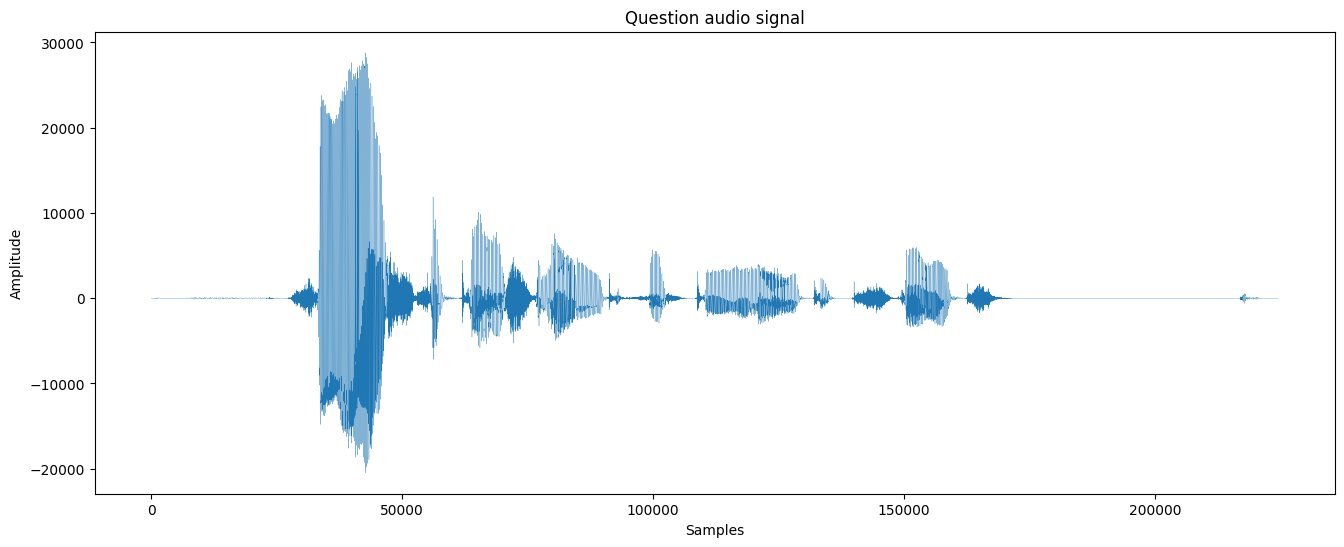

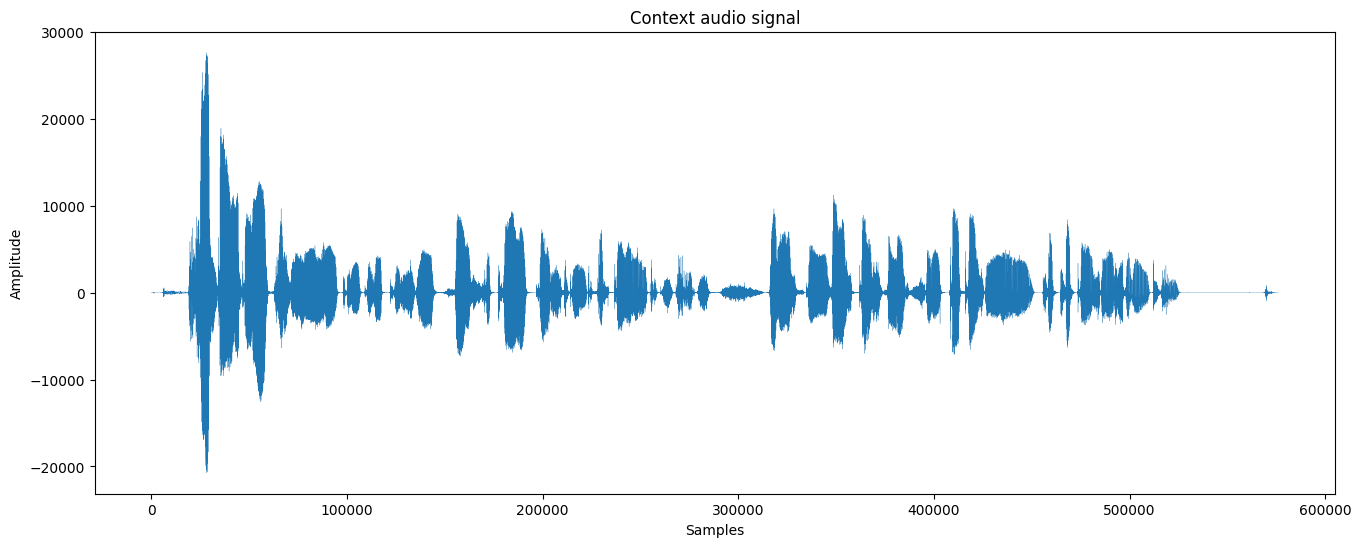

In [ ]:
# question
fig = plt.figure(figsize=(16, 6))
plt.plot(audio, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Question audio signal')
plt.show()

# context
fig = plt.figure(figsize=(16, 6))
plt.plot(audio_context, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Context audio signal')
plt.show()

Plot the amplitude with respect to time, knowing how many samples we have per second (sr) and the total duration of the audio file

Duration of the custom question audio signal: 4.68 s.



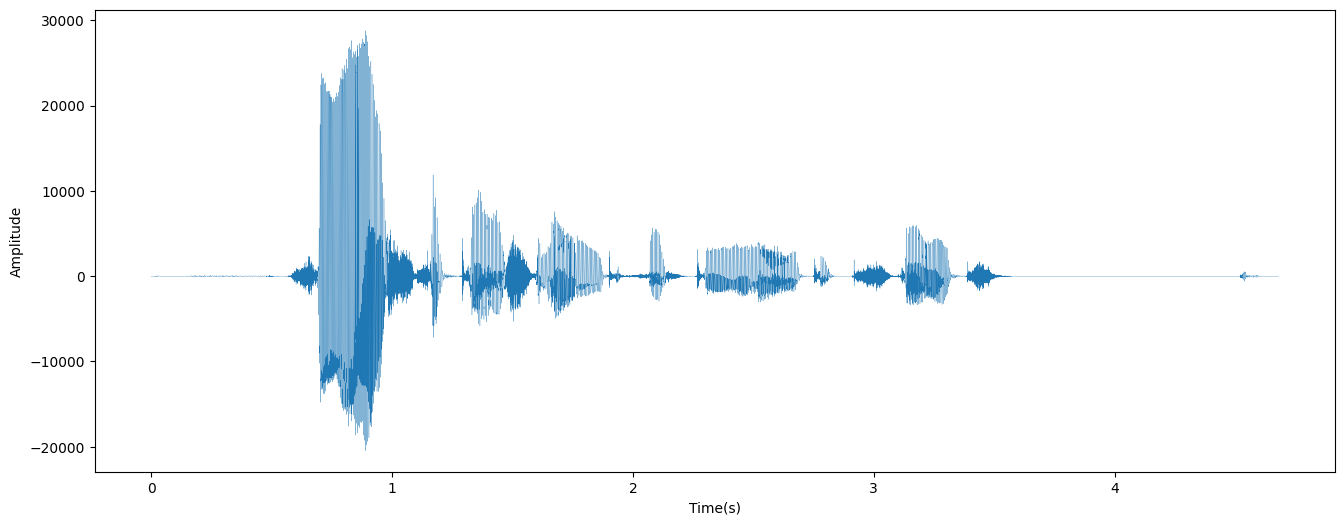

Duration of the custom context audio signal: 12.0 s.



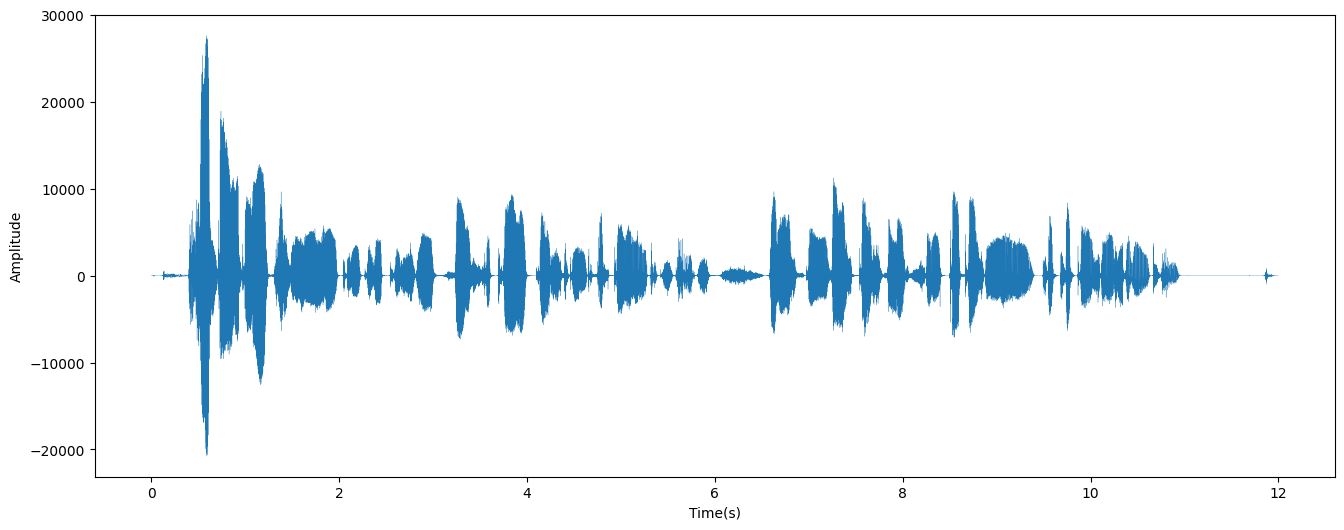

In [ ]:
# question
# get duration in seconds
audio_length = librosa.get_duration(y=audio, sr=sr)
size_audio = len(audio)
print("Duration of the custom question audio signal:", audio_length, "s.\n")
fig = plt.figure(figsize=(16, 6))
# change x axis to take into consideration time and not samples
plt.plot(np.linspace(0, audio_length, size_audio), audio, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.show()

# context
audio_length_context = librosa.get_duration(y=audio_context, sr=sr_context)
size_audio_context = len(audio_context)
print("Duration of the custom context audio signal:", audio_length_context, "s.\n")
fig = plt.figure(figsize=(16, 6))
plt.plot(np.linspace(0, audio_length_context, size_audio_context), audio_context, linewidth=0.2)
plt.ylabel('Amplitude')
plt.xlabel('Time(s)')
plt.show()




### Windowing
In general a signal is represented using frequency which is another measure of the wave in addition to the amplitude, and this is permitted by the Fast Fourier Transform (which permits to move from the time domain to the frequency domain). Before its implementation we need to ensure to make it work in the best way possible. This method has some limitation, thus it is required to perform some modifications on the signal before using it, that is, windowing. The assumption done by the FFT is that there is a finite set of data. It sees the time wave as circular, then as the two endpoints (edges) are connected, expecting the signal to have an integer number of periods. The problem is that often the two endpoints of the wave signal doesn't match (not continuous if connected together), thus not having an integer number of periods. This causes in the result of the FFT peaks of high frequency (sharp transitions) which are not present in the original signal, which cause a distorted result. Windowing is used to reduce these peaks by segmenting the signal into windows and smoothing the signal toward zero at the endpoints.

Different windowing methods can be used, and the Hann windowing is the one who permits the signal to touches the 0 value amplitude at the edges by smoothing the signal, thus removing all discontinuities.

### Mel histogram

In the mel histogram a non-linear function is applied to the frequency scale motivated by the human perception of sound (approximates the response of human ear to different frequencies). This is done since human ears are more sensible to changes in pitch at low frequencies rather than at high frequencies. In addition decibels are associated to frequency through a logarithmic scale, i.e. a small change in decibels results in a big variation in frequency.

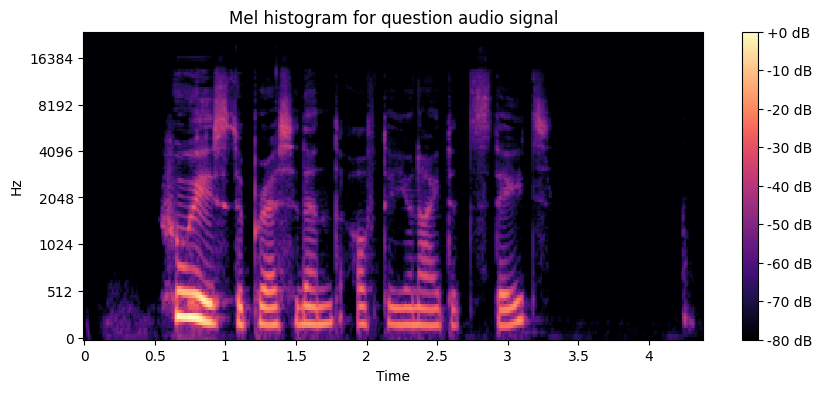

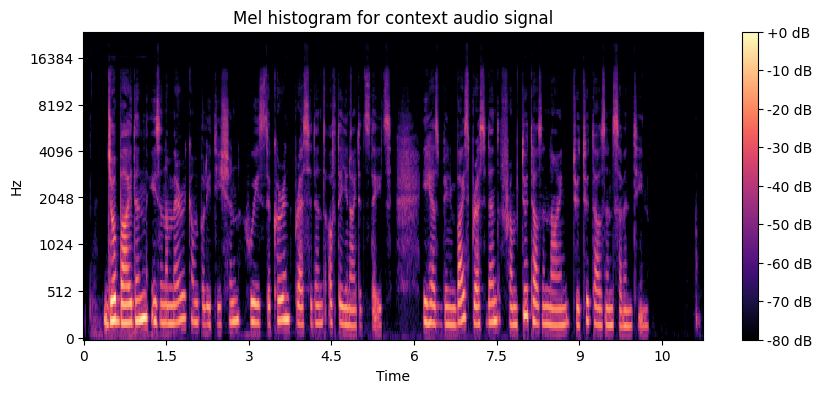

In [ ]:
nr_samples = int(math.floor(0.025*sr))
overlapping = int(math.floor(0.01*sr))
time_axis = np.arange(0, audio_length, 0.5)

# question
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, hop_length=overlapping, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel histogram for question audio signal')
plt.show()

# context
mel_spec_context = librosa.feature.melspectrogram(y=audio_context, sr=sr_context)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec_context, ref=np.max), sr=sr_context, hop_length=overlapping, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel histogram for context audio signal')
plt.show()

### Whisper model
The whisper model is the state of art of speech recognition: it permits a robust speech processing as well as the ability to recognise multiple languages. In this project we assume spoken questions are passed in English.

Even if we use one of the most powerful model, passing directly the .wav recordings doesn't permit to get most of the times a correct transcription which is very important in our project. We tried to use the large model and the precision improved, however the results are not as the level as we expected. A solution is to preprocess the audio files in combination with the usage of the large model: we apply normalisation (usually done also for images) which permit to speed up convergence, to improve generalisation (less sensitive to variations), etc., as well as noise reduction to have a clearer recording. The results improve even more if the recording is done with an artificial voice (e.g. the one of Google translator), since persons are not able to clearly spell out words.


In [ ]:
model = whisper.load_model("large")

100%|█████████████████████████████████████| 2.88G/2.88G [00:41<00:00, 75.1MiB/s]


In [ ]:
# result without preprocessing
# question
result = model.transcribe('audio.wav')
print("Transcription of the custom question audio: ", result['text'])

# context
result_context = model.transcribe('audio_context.wav')
print("Transcription of the custom context audio: ", result_context['text'])

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription of the custom question audio:   Who is the President of the United States?


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription of the custom context audio:   Joe Biden is an American politician who is the current President of the United States. He has been Vice President from 2009 to 2017.


In [ ]:
import noisereduce as nr
# result with preprocessing audio files
# normalize audio using mean and standard deviation and reduce noise

# question
# Compute mean and standard deviation
mean_value = np.mean(audio)
std_dev = np.std(audio)
# Normalize the audio
normalized_audio = (audio - mean_value) / std_dev
# reduce noise
reduced_noise = nr.reduce_noise(y=normalized_audio, sr=sr)
# store new  preprocessed audio file recorded before
scipy.io.wavfile.write('audio.wav', sr, reduced_noise)

# context
mean_value_context = np.mean(audio_context)
std_dev_context = np.std(audio_context)
normalized_audio_context = (audio_context - mean_value_context) / std_dev_context
reduced_noise_context = nr.reduce_noise(y=normalized_audio_context, sr=sr_context)
scipy.io.wavfile.write('audio_context.wav', sr_context, reduced_noise_context)

In [ ]:
result = model.transcribe('audio.wav')
print("Transcription of the custom question audio:", result['text'])

result_context = model.transcribe('audio_context.wav')
print("Transcription of the custom context audio:", result_context['text'])

question = result['text']
context = result_context['text']

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription of the custom question audio:  Who is the President of the United States?


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription of the custom context audio:  Joe Biden is an American politician who is the current President of the United States. He has been Vice President from 2009 to 2017.


## Fine-tuned model - BertForQuestionAnswering

In [ ]:
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the fine-tuned model
model = torch.load("/content/drive/MyDrive/finetunedmodel",map_location=torch.device('cpu'))

model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

The question and context are passed to the fine-tuned model after a tokenization and the answer is generated.

In [ ]:
inputs = tokenizer.encode_plus(question, context, return_tensors='pt')

outputs = model(**inputs)
# get the most likely beginning of answer with the argmax of the score
answer_start = torch.argmax(outputs[0])
answer_end = torch.argmax(outputs[1]) + 1

answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
print(answer)

joe biden


## Text-to-speech

For transforming text to speech we employ the Tacotron2 as well as WaveGlow. Tacotron2 is able to produce Mel spectrogram from a given text using an encoder-decoder architecture, thus we need WaveGlow which is able to produce audio files from Mel spectrograms. We load the Tacotron2 model pre-trained on LJ Speech dataset from NVIDIA's Deep Learning Examples repository as well as the pretrained WaveGlow model.

For better performance tacotron2 and waveglow are moved to the GPU if available ('cuda'), and they're then moved to the evaluation mode (remotion of some layers which are not necessary outside the training part). Weight normalisation is removed from waveglow since it is used for training purposes.

In [ ]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

In [ ]:
# pass answer as input
input_text = answer

Process the input using utilities to prepare it for TTS model.

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([input_text])

Combine Tacotron2 and WaveGlow.

torch.no_grad() disables gradient computation during its execution (for memory saving and computation speed up)

In [ ]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()

sr2 = 22050

Store audio file

In [ ]:
scipy.io.wavfile.write("text_to_speech.wav", sr2, audio_numpy)

Listen for the text

In [ ]:
sr, audio = scipy.io.wavfile.read("text_to_speech.wav")

reduced_noise = nr.reduce_noise(y=audio, sr=sr)
# store new  preprocessed audio file recorded before
scipy.io.wavfile.write('text_to_speech.wav', sr, reduced_noise)

sr, audio = scipy.io.wavfile.read("text_to_speech.wav")

# Display the audio player widget
Audio(data=audio, rate=sr)

## Investigate how effective and reliable the voice interactive components are. If they are not particularly reliable, how might you change them to make them more robust?


The Whisper model required some attention probabily due to the bad quality of the audio as well as using human voices: each voice is unique, with different accents, tones, voice's cadence, and each person spells out words in a different way. In addition there are homophones (words that sound the same) and homographs (words spelled the same). Because of these reasons, predicting a transcription of an audio can be really challenging. On the other hand, predicting a signal audio from text (Tacotron2 + WaveGlow) can be more trivial as long as the correct text is passed as input, since a specific text is represented and can be represented only in a unique way without all the variables we can have in an audio signal.

Because of all variables we can encounter with a voice signal, the preprocessing is applied on the voice input of the Whisper model (normalisation and noise reduction), and the results improved significantly.

With some input recordings using only human's voice we have been able to compute the Word Error Rate in a string in average (WER, how many detected words differ from correct words) and Sentence Error Rate (SER, how many sentences had at least one error) of the predicted output of the Whisper model with and without preprocessing:

**Without preprocessing**

WER = 100 * (insertions + substitutions + deletions) / total words in correct transcript = 100 * # of questions with at least one error / total number of sentences = 41.94%

SER = 55.55%

**With preprocessing**

WER = 0%

SER = 0%


From the point of view of the Text-To-Speech, the result of WaveGlow is for the majority of the time clear and clean, but with some words (e.g. proper nouns) it is more complex to understand the resulted audio signal. The result can may be improved by fine-tuning Tacotron2 and WaveGlow on our dataset that can permit the models to adapt to specific linguistic patterns. What it should also possible to do is to perform some post-processing in order to smooth the audio signal and making it more 'natural'.

# LLM (Large Language Model) effectiveness on task
To check the effectiveness on the task of question answering as LLM we use GPT-2 (Generative Pre-trained Transformer 2) since BERT has been already used in this project. GPT-2 is a decoder-only architecture which can be used for text prediction and text classification. GPT-2 is a more recent system and it doesn't require to receive as input the context to search for the answer as BERT needs (no extractive base).

 Few shots learning is a definition in which a model is expected to perform a task without being explicitly trained on examples of that task during the training phase, but passing some examples at inference time. This is a method in the category of 'meta-learning', i.e. learning to learn. This type of learning can be used on a pre-trained model such that it will be able to generalise on new categories of data (or new tasks) using only few samples by the mean of similarity. There is no need to re-train the model since it has already been trained and training is time consuming and complex, and this similarity can be exploited precisely thanks to this pre-training.

 For a more interesting analysis, we didn't use the model gpt-2 for question answering but the generagl text generator model.

With GPT-2 we need to pay attention to the parameters we pass to it, and there are a few:
- input_ids = input sequence represented as a tensor of token IDs. It is the tokenized form of the text you want to use as a prompt for text generation.

- max_length = maximum length of the generated sequence (the generation process stops once this length is reached). Very high values can lead to less coherent outputs (we assume the answer whould be included in the first 100 elements)

- num_beams = Beam search is a search algorithm that explores multiple possible sequences in parallel, then num_beams controls the number of beams to use. Higher values can lead to more different outputs but also increase the computation time.

- no_repeat_ngram_size = prevents the model from repeating n-grams in the generated text. Higher values help in avoiding repetitive sentences.

- top_k = limits the number of tokens considered during the sampling process (it keeps the top-k most likely next tokens). Higher values can make the generation more focused, but too high values can result in overly deterministic outputs.

- top_p = controls the cumulative probability of the highest probability tokens to consider. It keeps the top-p probability mass in the distribution. Higher values (e.g., 0.95) allow for a broader selection of tokens.

- temperature = controls the randomness of the generation. Higher values (e.g. 1.0) make the outputs more random, while lower values (e.g. 0.7) make the outputs more deterministic and focused.

GPT2LMHeadModel is a general-purpose language model and it is not fine-tuned for specific tasks (there is already a GPT-2 model with the specific purpose of generating answers given questions), and because of this it is the best option to perform zero/few-shot learning for question answering.



## Zero-shot learning
For the zero-shot learning we pass to the model only the question input and the context, without any example.

In [ ]:
# Load pre-trained GPT-2 model and tokenizer
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt = GPT2LMHeadModel.from_pretrained('gpt2')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Pass context (question answering).

In [ ]:
task_description = 'Answer correctly the question:'

In [ ]:
def get_gpt_answer(input, examples = None):
    # Tokenize input text
    if examples:
        gpt_input_ids = tokenizer_gpt.encode(task_description + examples + input, return_tensors="pt")
    else:
        gpt_input_ids = tokenizer_gpt.encode(task_description + input, return_tensors="pt")

    # Create an attention mask tensor with the same shape as the input tensor with values 1
    mask = torch.ones_like(gpt_input_ids)

    # Generate output with attention_mask and pad_token_id explicitly set
    # Adjust max_length dynamically (so that the output text generated is always at maximum 100 chars)
    max_length = len(gpt_input_ids[0]) + 101
    output = model_gpt.generate(
        gpt_input_ids,
        max_length=max_length,
        num_beams=10,
        no_repeat_ngram_size=2,
        attention_mask=mask,
        pad_token_id=50256
    )

    # Decode and return only the generated output
    gpt_result = tokenizer_gpt.decode(output[0], skip_special_tokens=True)
    # Remove task_description, examples, and input from the generated text
    if examples:
        gpt_result = gpt_result.replace(task_description, '').replace(examples, '').replace(input, '').strip()
    else:
        gpt_result = gpt_result.replace(task_description, '').replace(input, '').strip()

    return gpt_result


Types of questions: Fact-based questions, temporal questions, general knowledge questions


In [ ]:
questions = [
             'Who was Napoleon?',
             'Who was the first woman to win a Nobel Prize?',
             'How many planets are there in our solar system?',
             'When did the Industrial Revolution begin?',
             'When did the Great Wall of China construction begin?',
             'When did the World War I start?',
             'Who wrote Romeo and Juliet?',
             'What is the largest mammal on Earth?',
             'Which is the full name of the chemical symbol H?'
]

expected_answers = [
                "He was a French emperor and military commander who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars.",
                "Marie Curie.",
                "8.",
                "1760.",
                "Its construction started in the 7th Century BC by the Chu State and completed in 1878.",
                "1914.",
                "William Shakespeare.",
                "The blue whale.",
                "Hydrogen"
                ]

In [ ]:
for i in range(0, len(questions)):
  print('\nQuestion:', questions[i])
  ans = get_gpt_answer(questions[i])
  print("Generated answer:",ans)
  print("Expected answer:", expected_answers[i])

### Conclusion zero-shot learning
In general the model get the topic of the question but often it is not able to generate the answer for the specific question. It seems to perform better on very simple and well-known questions (e.g. date of known events or general description of words or very famous persons).
To perform an evaluation, we compute the number percentage of Correct Answers with respect to all questions (0.5 if the answer is partially correct):

CA = 100 * correct answers/ given answers = 2.5/7 = 35.71%




## Few-shot learning
The general difference between few-shot learning and fine-tuning is that in fine-tuning it is used a pre-trained model that is already able to perform the specific task but we train it on a new dataset to improve the results on those new data. The few-shot learning, on the other hand, is done at inference time on a pre-trained model that perform a task using few samples for each class such that it is able to perform the task we need. In this case we should pass the task description, few examples of the task (question answering) and the question.

Examples (same for each question since the task is the same).

In [ ]:
examples = '''Examples:
How many colors are in the rainbow? 7.
Where is Big Ben located? London, England.
Where is the Eiffel Tower located? Paris, France.
How many branches comprise the federal government of the United States? 3 — legislative, executive and judicial.
What type of fruit "keeps the doctor away"? An apple a day.
Who was Einstein? Albert Einstein was a German-born theoretical physicist who is widely held to be one of the greatest and most influential scientists of all time.
When did the Second World War start? 1914.
Who was the first person on the moon? The American astronaut Neil Armstrong.
How many elements are in the periodic table? 118
In which period did pangea form? In the Middle Jurassic.
What country has the highest life expectancy? Hong Kong.
Who was the last Tsar of Russia? Nicholas II.
Who discovered that the earth revolves around the sun? Nicolaus Copernicus.
What planet is closest to the sun in our Solar System? Mercury.
Who was Marie Curie? She was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
When did the Cold War start? 1947.
When did the Cold War end? 1991.
How many planets have rings? Four: Jupiter, Saturn, Uranus, and Neptune.
'''

In [ ]:
for i in range(0, len(questions)):
  print('\nQuestion:', questions[i])
  ans = get_gpt_answer(questions[i], examples)
  print("Generated answer:",ans)
  print("Expected answer:", expected_answers[i])

### Conclusion few-shot learning
It is possible to notice that again the answers are not accurate and it seems the model is not able to understand it has to answer in a correct way to the questions. But on the other hand, the structure (type) of the answers is very different and more 'suitable' for a question-answer system. Despite of this, it seems we implemented in the wrong way the few-shot learning, since the model should be able to perform correctly the task given.

CA = 100 * correct answers/ given answers = 0.5/8 = 6.25%

## Few shot learning modification
Since passing questions and answers doesn't permit the model to compose correct answers, we decide to pass also the contexts. This option has been taken into consideration since the gpt-2 model for question anwering require a question and a context to generate an answer, thus there is the possibility this will help the performance of the model. Unfortunately, due to some problems with the length of the input, we can pass only at most 3 examples to the model.

More specified task description

In [ ]:
task_description = "Answer the following question based on the provided context."


Examples containing context, question and answer.

In [ ]:
examples = [
    {'context': "The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (\"Norman\" comes from \"Norseman\") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia.", 'question': "In what country is Normandy located?", 'answer': "France."},
    {'context': "Southern California, often abbreviated SoCal, is a geographic and cultural region that generally comprises California's southernmost 10 counties. The region is traditionally described as \"eight counties\", based on demographics and economic ties: Imperial, Los Angeles, Orange, Riverside, San Bernardino, San Diego, Santa Barbara, and Ventura.", 'question': "What is Southern California often abbreviated as?", 'answer': "SoCal."},
    {'context': "Huguenot numbers peaked near an estimated two million by 1562, concentrated mainly in the southern and central parts of France, about one-eighth the number of French Catholics. As Huguenots gained influence and more openly displayed their faith, Catholic hostility grew, in spite of increasingly liberal political concessions and edicts of toleration from the French crown.", 'question': "Where was France's Huguenot population largely centered?", 'answer': "The southern and central parts of France."},
    {'context': "Within southern California are two major cities, Los Angeles and San Diego, as well as three of the country's largest metropolitan areas. With a population of 3,792,621, Los Angeles is the most populous city in California and the second most populous in the United States. To the south and with a population of 1,307,402 is San Diego, the second most populous city in the state and the eighth most populous in the nation.", 'question': "Which city is the most populous in California?", 'answer': "Los Angeles."},
]

Contexts and questions for which the model should generate the answers. The predicted output will then be compared to the correct answer.

In [ ]:
target_contexts = [
                   "The Black Death is thought to have originated in the arid plains of Central Asia, where it then travelled along the Silk Road, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30\u201360% of Europe's total population. In total, the plague reduced the world population from an estimated 450 million down to 350\u2013375 million in the 14th century. The world population as a whole did not recover to pre-plague levels until the 17th century. The plague recurred occasionally in Europe until the 19th century.",
                   "There are three major types of rock: igneous, sedimentary, and metamorphic. The rock cycle is an important concept in geology which illustrates the relationships between these three types of rock, and magma.",
                   "The word pharmacy is derived from its root word pharma which was a term used since the 15th\u201317th centuries. However, the original Greek roots from pharmakos imply sorcery or even poison. In addition to pharma responsibilities, the pharma offered general medical advice and a range of services that are now performed solely by other specialist practitioners, such as surgery and midwifery. The pharma (as it was referred to) often operated through a retail shop which, in addition to ingredients for medicines, sold tobacco and patent medicines.",
                   "One of its earliest massive implementations was brought about by Egyptians against the British occupation in the 1919 Revolution. Civil disobedience is one of the many ways people have rebelled against what they deem to be unfair laws. It has been used in many nonviolent resistance movements in India (Gandhi's campaigns for independence from the British Empire), in Czechoslovakia's Velvet Revolution and in East Germany to oust their communist governments, In South Africa in the fight against apartheid.",
                   "Construction is the process of constructing a building or infrastructure. Construction differs from manufacturing in that manufacturing typically involves mass production of similar items without a designated purchaser, while construction typically takes place on location for a known client. Construction as an industry comprises six to nine percent of the gross domestic product of developed countries. Construction starts with planning,[citation needed] design, and financing and continues until the project is built and ready for use."
                   ]

target_questions = [
                    "For how long did the plague stick around?",
                    "What are the three major types of rock?",
                    "What goods were sold in a pharma?",
                    "What is it called when people in society rebel against laws they think are unfair?",
                    "What is the process of constructing a building or infrastructure?"
                    ]

answers_expected = [
                  "Until the 19th century.",
                  "Igneous, sedimentary, and metamorphic.",
                  "Ingredients for medicines, sold tobacco and patent medicines",
                  "Civil disobedience.",
                  "Construction."
                  ]


In [ ]:
def get_gpt_answer_modified(target_context, target_question, examples):
  # Concatenate task description, examples, and target context-question pair
  few_shot_input = task_description + "\n\n" + "\n".join([f"Context: {example['context']}\nQ: {example['question']}\nA: {example['answer']}" for example in examples]) + f"\n\nContext: {target_context}\nQ: {target_question}"
  gpt_input_ids = tokenizer_gpt.encode(few_shot_input, return_tensors="pt")

  # Create an attention mask tensor with the same shape as the input tensor with values 1
  mask = torch.ones_like(gpt_input_ids)

  # Adjust max_length dynamically
  min_length = len(gpt_input_ids[0]) + 101
  # Generate output with attention_mask and pad_token_id explicitly set
  mask = torch.ones_like(gpt_input_ids)

  # Model Inference
  output = model_gpt.generate(
      gpt_input_ids,
      min_length=min_length,
      max_new_tokens = 300,
      num_beams=10,
      no_repeat_ngram_size=2,
      attention_mask=mask,
      pad_token_id=50256
  )
  # Decode and return only the generated output
  gpt_result = tokenizer_gpt.decode(output[0], skip_special_tokens=True)
  # Remove the input part from the generated output
  gpt_result = gpt_result.replace(few_shot_input, '').strip()
  return gpt_result

In [ ]:
for i in range(0, len(target_questions)):
  print("\nQuestion:", target_questions[i])
  ans = get_gpt_answer_modified(target_contexts[i], target_questions[i], examples)
  print("Generated answer:", ans)
  print("Expected answer:", answers_expected[i])


Question: For how long did the plague stick around?
Generated answer: How did it spread? What was it like to live in a place where there was no plague at all? A: It was not uncommon for a plague to spread from one place to another within a short period of time. For example, during the Middle Ages, plague outbreaks were more common in southern France than in central and eastern Europe. During the Renaissance, there were also outbreaks of plague in northern Italy and northern Spain, but they were not as widespread as they would have been if plague had not been a major cause of death in those regions.
Expected answer: Until the 19th century.

Question: What are the three major types of rock?
Generated answer: How do they relate to each other and to the rest of our planet? What does it mean to be a "rock" or "magma" and what does that mean for us as a species? A rock is composed of two or more elements, such as carbon, oxygen, nitrogen, phosphorus, potassium, calcium, magnesium, sulfur, c

### Conclusion modified few-shot learning
Again the model is not able to generated the required answer even if we both pass both questions and contexts. If also this approach doesn't work this means the implementation of few-shot learning should be implemented in a different way, or there is also the possibility that the structure of the model is not able to generate the answer in the way we expect, but this is less probable.

## General conclusion
Implementing zero-shot learning and few-shot learning has proven challenging due to conflicting explanations from various online sources. The only consensus among these sources is that zero-shot learning involves providing no examples, while few-shot learning requires a limited set of examples (typically 10-100). Initially, we attempted to implement few-shot learning by fine-tuning the model, supplying task instructions, examples, and questions. Unfortunately, this approach yielded no improvement in performance. Subsequent efforts to train the model using different methods and parameters also proved unsuccessful. Ultimately, after thorough documentation and research, we discovered sources suggesting that shot-learning should occur at inference time when the model generates output text. Despite our implemented approach, it appears we may not have understood this process fully. Although GPT-2 demonstrates an understanding of the structure it has to provides for answers, it struggles to comprehend the question's meaning well enough to generate accurate replies (even with the help of a context).

# References
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/


https://stackoverflow.com/a/18650249


https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/


https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/


https://stackoverflow.com/a/49019356


https://librosa.org/doc/main/index.html

https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf

https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

https://stackoverflow.com/questions/66451430/changes-in-gpt2-gpt3-model-during-few-shot-learning